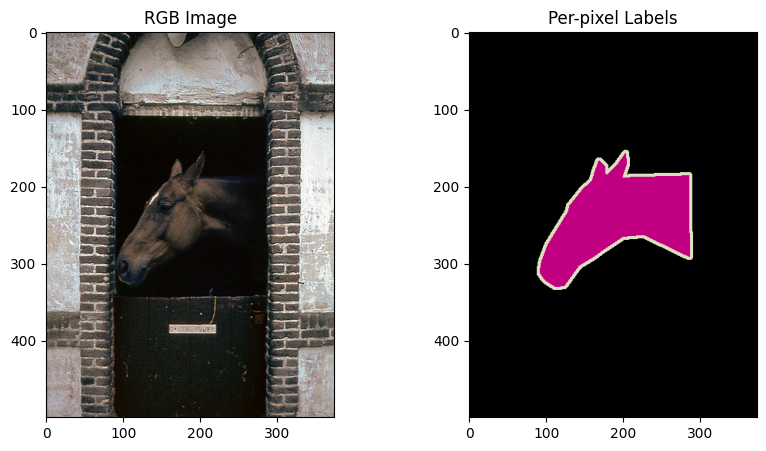

In [38]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt

# Paths
train_images_path = 'student-dataset/student-dataset/JPEGImages/train'
train_labels_path = 'student-dataset/student-dataset/SegmentationClass/train'

# Example: Load an image and its corresponding label
image_filename = '0a02da60-749d-4601-9f98-377981bd5336.jpg'
label_filename = image_filename.replace('.jpg', '.png')  # Assuming labels are in PNG format

image = Image.open(os.path.join(train_images_path, image_filename))
label = Image.open(os.path.join(train_labels_path, label_filename))

# Visualize
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('RGB Image')

plt.subplot(1,2,2)
plt.imshow(label, cmap='gray')
plt.title('Per-pixel Labels')
plt.show()


In [39]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform_image=None, transform_label=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.images = [img for img in os.listdir(images_dir) if img.endswith('.jpg')]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        image_path = os.path.join(self.images_dir, img_name)
        label_name = img_name.replace('.jpg', '.png')
        label_path = os.path.join(self.labels_dir, label_name)

        try:
            # Load image
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        try:
            # Load label
            label = Image.open(label_path)
        except Exception as e:
            print(f"Error loading label {label_path}: {e}")
            raise e

        # Apply image transformations
        if self.transform_image:
            image = self.transform_image(image)
        
        # Apply label transformations
        if self.transform_label:
            label = self.transform_label(label)
            label = torch.as_tensor(np.array(label), dtype=torch.long)
        
        return image, label

In [40]:
# Image transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])
])

# Label transformations
transform_label = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize labels
    transforms.PILToTensor()  # Convert to tensor without normalization
    # Note: PILToTensor() converts to [C, H, W], but labels are single-channel
    # We'll handle it appropriately in __getitem__
])

In [41]:
# Paths (update these paths accordingly)
train_images_path = 'student-dataset/student-dataset/JPEGImages/train'
train_labels_path = 'student-dataset/student-dataset/SegmentationClass/train'

# Instantiate dataset with synchronized transformations
train_dataset = SegmentationDataset(
    images_dir=train_images_path,
    labels_dir=train_labels_path,
    transform_image=transform_image,
    transform_label=transform_label
)

# Instantiate DataLoader with num_workers=0 for debugging
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,  # Set to >0 after debugging
    pin_memory=True  # Optional: can improve performance if using GPU
)

In [45]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Initialize the model
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 22, kernel_size=(1, 1), stride=(1, 1))  # 22 classes

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)  # 255 is the void label
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Device being used: cpu
CUDA is not available. Using CPU.


In [43]:
num_epochs = 25
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if images is None or labels is None:
            print(f"Skipping batch {batch_idx} due to loading error.")
            continue

        images = images.to(device)
        labels = labels.squeeze(1).to(device)  # Ensure labels are [batch, H, W]

        optimizer.zero_grad()
        outputs = model(images)['out']  # [batch, 22, H, W]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed.")

KeyboardInterrupt: 